In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

%config InlineBackend.figure_format = 'retina'


In [2]:
# Generate XOR dataset with padding and noise
def generate_xor_data(num_samples=200, noise=0.0):
    def get_xor_label(x, y):
        return 1 if x * y >= 0 else -1

    padding = 0.3
    points = []

    for _ in range(num_samples):
        x = np.random.uniform(-5, 5)
        x += padding if x > 0 else -padding  # Padding
        y = np.random.uniform(-5, 5)
        y += padding if y > 0 else -padding

        noise_x = np.random.uniform(-5, 5) * noise
        noise_y = np.random.uniform(-5, 5) * noise

        # Ensure labels are 0 or 1
        label = 1 if get_xor_label(x + noise_x, y + noise_y) == 1 else 0
        points.append([x, y, label])

    points = np.array(points)
    X = points[:, :2]  # Extract coordinates
    y = points[:, 2]   # Extract labels
    return X, y

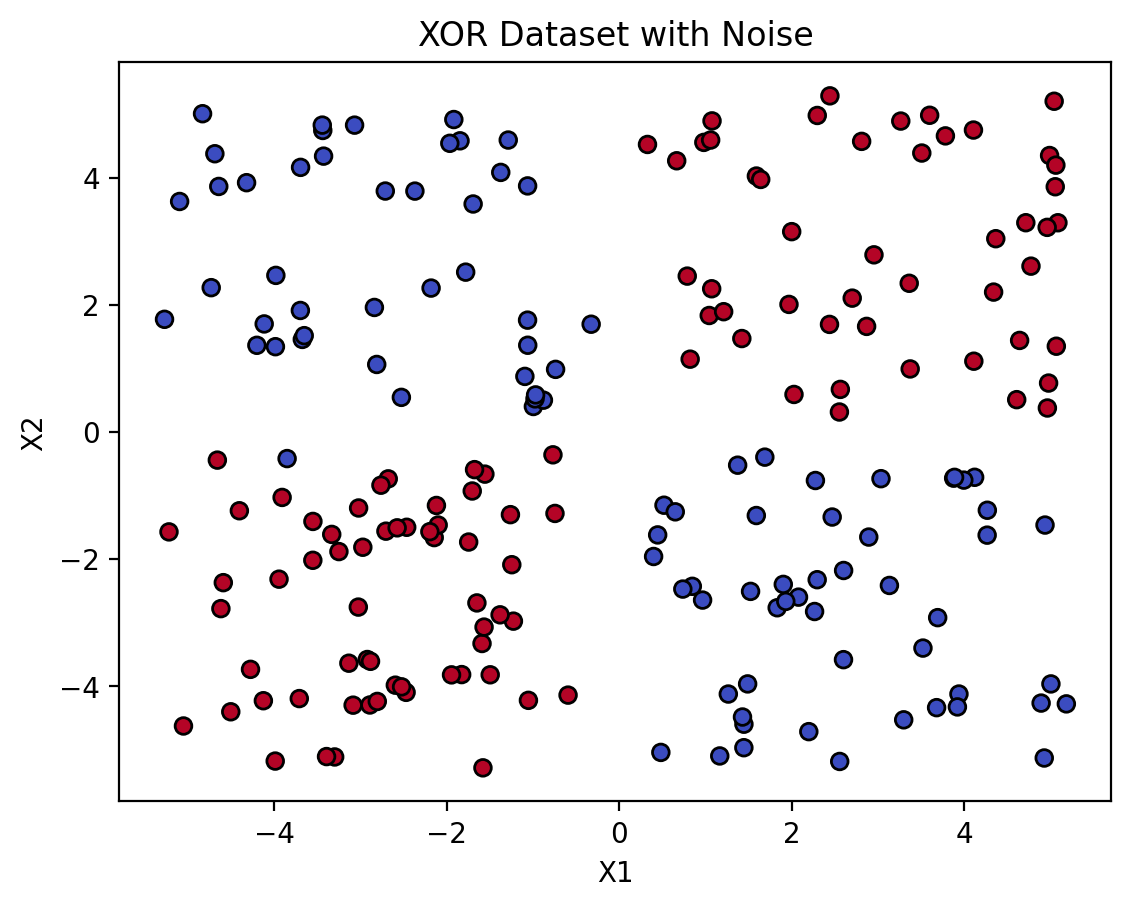

In [3]:
# Set global seeds and enforce deterministic behavior
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Example usage
X_train, y_train = generate_xor_data(num_samples=200, noise=0.1)
X_test, y_test = generate_xor_data(num_samples=200, noise=0.1)

# Plot the generated dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", edgecolors="k")
plt.title("XOR Dataset with Noise")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [4]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [5]:
#Print Shapes of the tensors
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([200, 2])
torch.Size([200, 1])
torch.Size([200, 2])
torch.Size([200, 1])


## MLP

In [6]:
# Plot Decision Boundary for XOR Data
def plot_decision_boundary(model, X, y, title="MLP Decision Boundary on XOR Data"):
    model.eval()
    # Define bounds
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Get model predictions over the grid
    with torch.no_grad():
        Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = Z.reshape(xx.shape).numpy()

    # Plot decision boundary with color map
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.6)

    # Scatter the points with labels
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')

    # Add a color bar to indicate the predicted probabilities
    cbar = plt.colorbar(contour)
    cbar.set_label("Predicted Class Probability", rotation=270, labelpad=15)

    # Set labels and title
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)

    # Display legend
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

In [7]:
# Calculate accuracy
def calculate_accuracy(model, X_test_tensor, y_test_tensor):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_predictions = (outputs > 0.5).float()
        
        # Convert tensors to numpy arrays for compatibility with accuracy_score
        test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy()) * 100
        print(f"Accuracy: {test_accuracy:.2f}%")
        

    return test_accuracy


In [8]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=10, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [9]:
# Initialize model, loss function, and optimizer
model = MLP()
criterion = nn.BCELoss()   # Binary Cross-Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    # Forward pass
    outputs = model(X_train_tensor)

    # Print shape once or periodically for verification
    if epoch == 0:
        print(f"Output shape: {outputs.shape}, Target shape: {y_train_tensor.shape}")

    # Calculate loss
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Output shape: torch.Size([200, 1]), Target shape: torch.Size([200, 1])
Epoch [100/500], Loss: 0.0785
Epoch [200/500], Loss: 0.0358
Epoch [300/500], Loss: 0.0236
Epoch [400/500], Loss: 0.0178
Epoch [500/500], Loss: 0.0146


For Training Data:
Accuracy: 99.50%
For Testing Data:
Accuracy: 98.50%


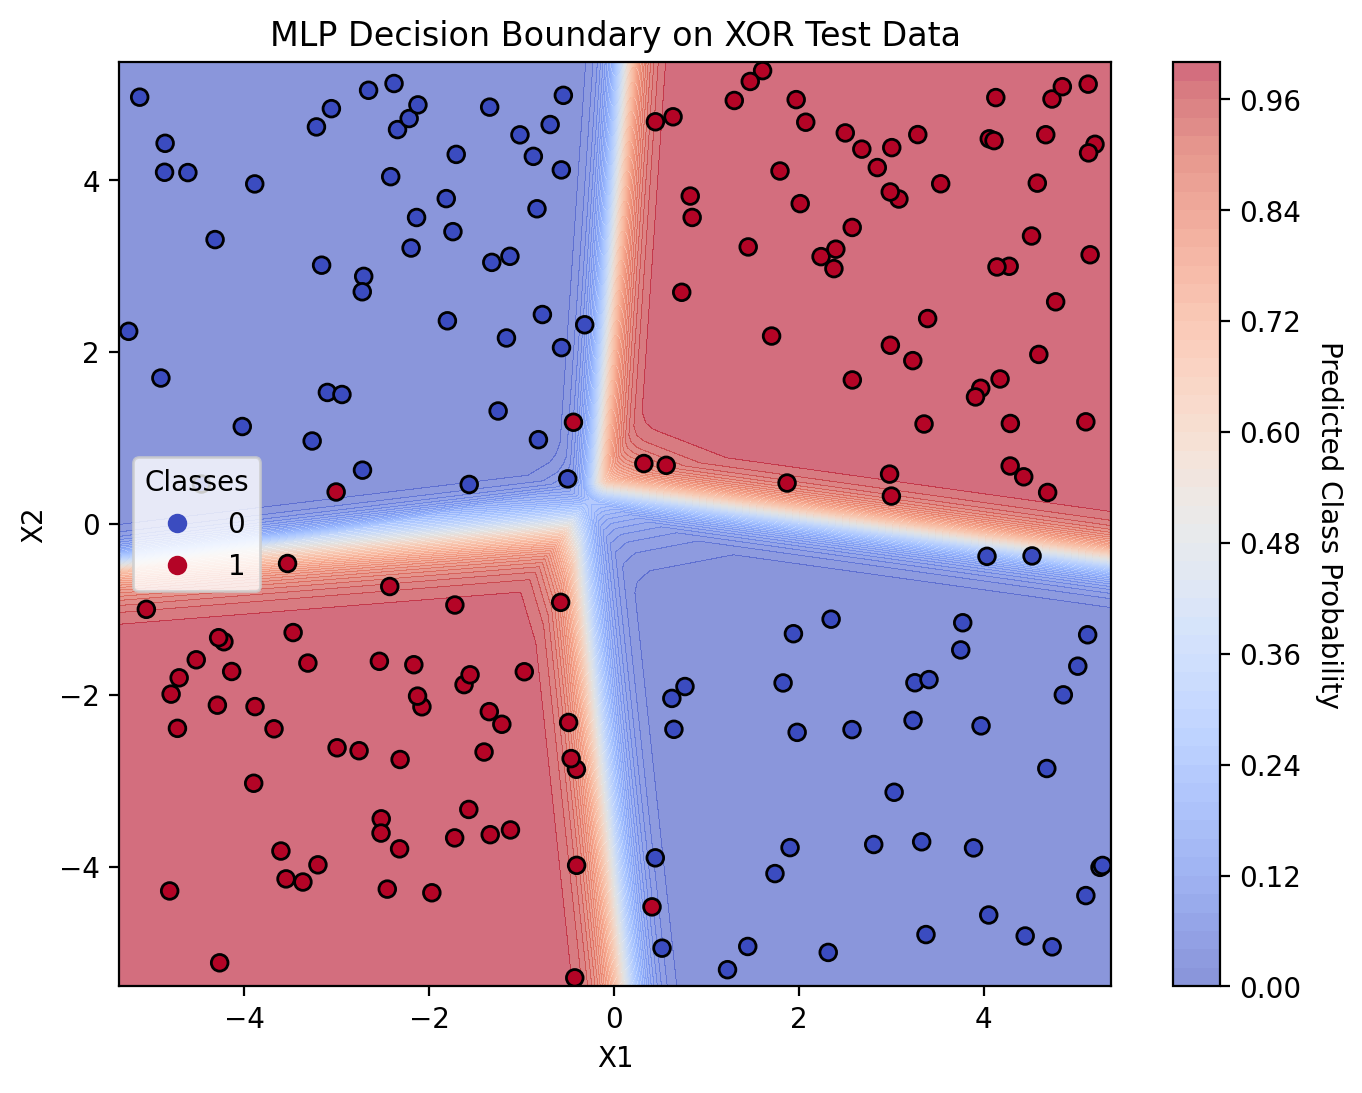

In [10]:
print("For Training Data:")
train_accuracy = calculate_accuracy(model, X_train_tensor, y_train_tensor)
print("For Testing Data:")
test_accuracy = calculate_accuracy(model, X_test_tensor, y_test_tensor)

# Visualize decision boundary for the MLP model
plot_decision_boundary(model, X_test, y_test, title="MLP Decision Boundary on XOR Test Data")

Since MLPs can learn complex non-linear functions, the decision boundary closely captures the XOR pattern, forming a cross-like structure or two distinct regions. It can easily capture non linear function since we used non-linear activation function.  The MLP’s ReLU activation in the hidden layer enables it to capture XOR’s non-linear pattern, which is vital for XOR classification. Sigmoid at the output layer helps model binary probabilities. 

This model has the highest training accuracy since it has no constraints and can freely adapt to the training data. However, this often leads to overfitting, meaning it might perform worse on the test set if the model is too flexible. There might be some changes in accuracy based on dataset provided.  

A well-trained MLP should distinguish the XOR regions well, with decision boundaries appearing sharp and accurately separating the two classes. Without regularization, MLP fits training data well but risks overfitting to noise, especially if trained too long. This risk is mitigated with L1 or L2 regularization, as shown below.

## MLP with L1 Regularization


In [11]:
# Function to train the model with L1 regularization and return validation accuracy
def train_model_with_l1(X_train, y_train, X_val, y_val, input_size, hidden_size, output_size, l1_lambda, num_epochs, learning_rate=0.01):
    torch.manual_seed(0)
    np.random.seed(0)
    # Instantiate the model, loss function, and optimizer
    model = MLP(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with L1 regularization
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Compute L1 regularization term
        l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())
        loss += l1_lambda * l1_norm

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate validation accuracy
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = (val_predictions == y_val).float().mean().item() * 100

    return model, val_accuracy

In [12]:
X_train_l1, X_val_l1, y_train_l1, y_val_l1 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Convert data to tensors
X_train_l1_tensor = torch.FloatTensor(X_train_l1)
y_train_l1_tensor = torch.FloatTensor(y_train_l1).view(-1, 1)
X_val_l1_tensor = torch.FloatTensor(X_val_l1)
y_val_l1_tensor = torch.FloatTensor(y_val_l1).view(-1, 1)

In [13]:
# Function to plot validation accuracy vs lambda
def plot_lambda_vs_accuracy(l1_lambdas, validation_accuracies, title):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(l1_lambdas, validation_accuracies, marker='o', color='b', label='Validation Accuracy')

    plt.xlabel("L1 Lambda")
    plt.ylabel("Validation Accuracy (%)")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis to show each lambda value and display in logarithmic scale if needed
    plt.xticks(l1_lambdas)  # show each lambda value as tick
    plt.xscale('log')  # optional: use log scale for better visibility if lambdas vary greatly
    plt.ylim(20,105)
    plt.legend()
    plt.show()

L1 Lambda: 0.001, Validation Accuracy: 100.00%
L1 Lambda: 0.005, Validation Accuracy: 100.00%
L1 Lambda: 0.01, Validation Accuracy: 100.00%
L1 Lambda: 0.03, Validation Accuracy: 100.00%
L1 Lambda: 0.05, Validation Accuracy: 85.00%
L1 Lambda: 0.1, Validation Accuracy: 50.00%
L1 Lambda: 0.5, Validation Accuracy: 50.00%

Best L1 Lambda: 0.03, Best Validation Accuracy: 100.00%


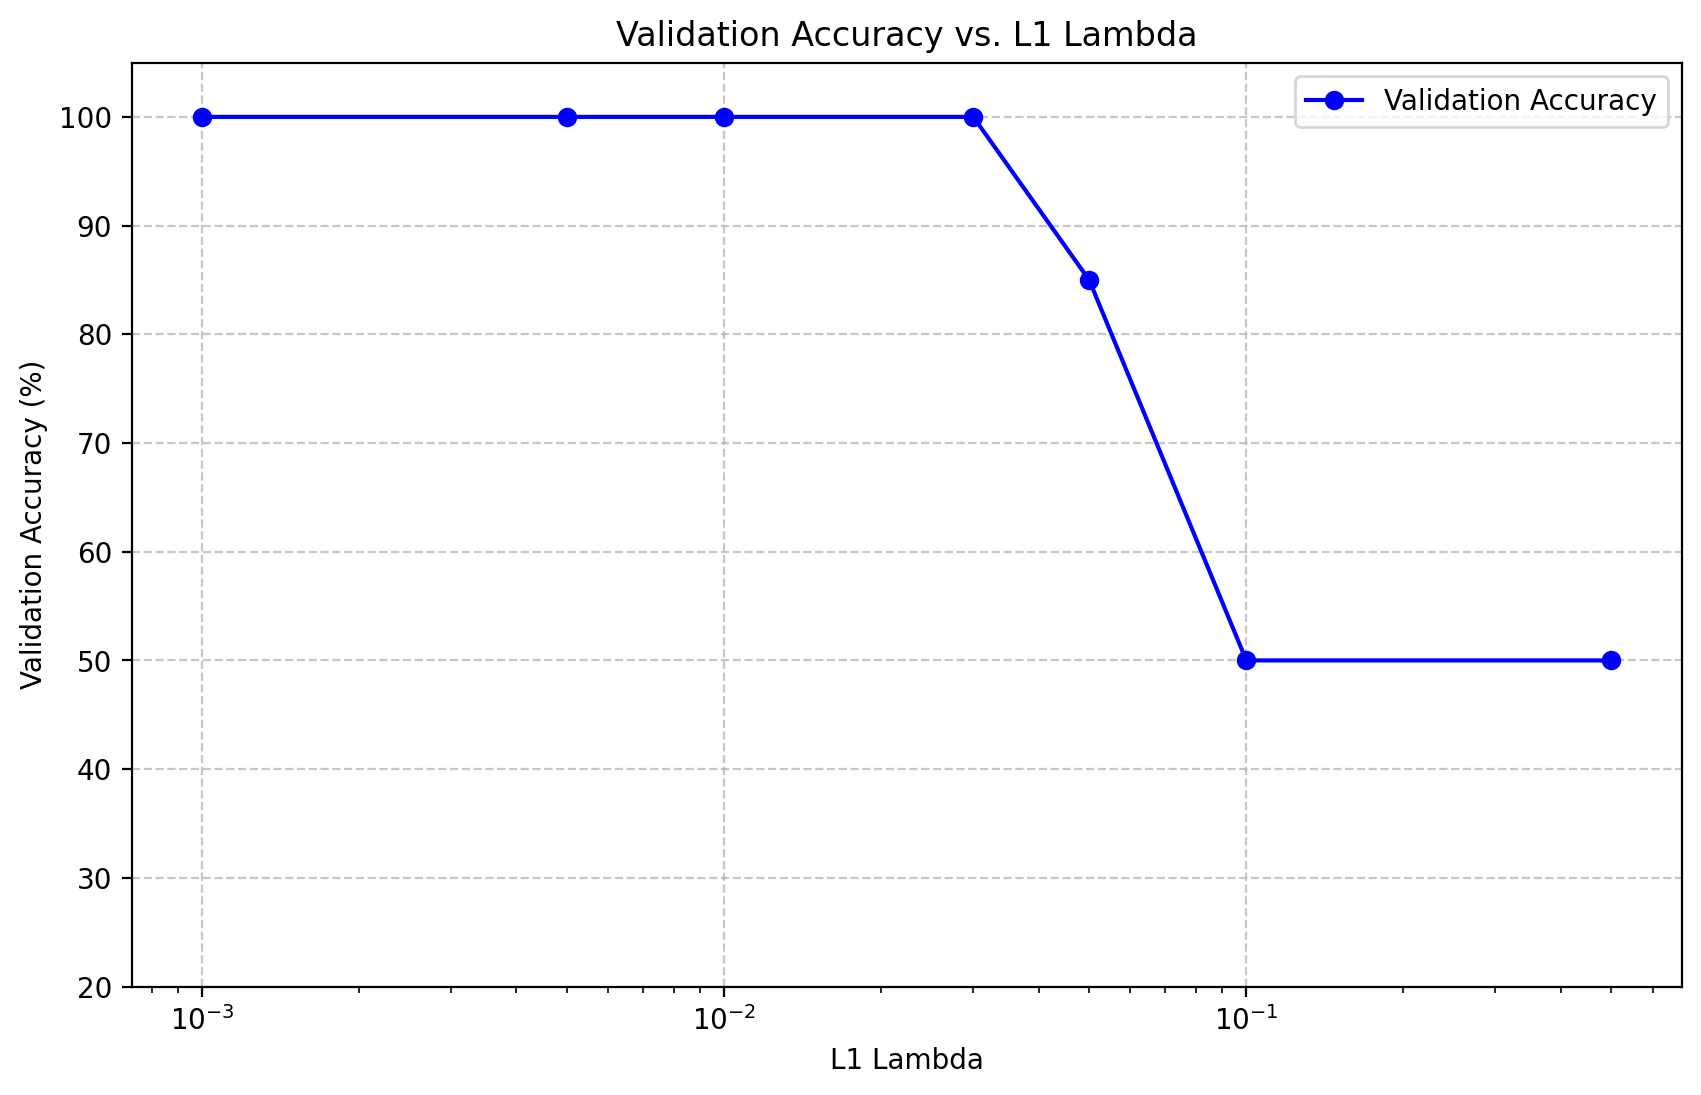

In [14]:
# Main training loop to evaluate and store validation accuracy for each L1 lambda
l1_lambdas = [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.5]
validation_accuracies = []
best_val_accuracy = 0
best_l1_lambda = None

# Train model for each lambda value and record validation accuracy
for l1_lambda in l1_lambdas:
    _, val_accuracy = train_model_with_l1(
        X_train_l1_tensor, y_train_l1_tensor, X_val_l1_tensor, y_val_l1_tensor,
        input_size=2, hidden_size=10, output_size=1,
        l1_lambda=l1_lambda, num_epochs=100, learning_rate=0.01
    )

    validation_accuracies.append(val_accuracy)
    print(f"L1 Lambda: {l1_lambda}, Validation Accuracy: {val_accuracy:.2f}%")

    # Update best l1_lambda based on validation accuracy
    if val_accuracy >= best_val_accuracy:  
        best_val_accuracy = val_accuracy
        best_l1_lambda = l1_lambda


print(f"\nBest L1 Lambda: {best_l1_lambda}, Best Validation Accuracy: {best_val_accuracy:.2f}%")

# Plot the validation accuracies for different lambda values
plot_lambda_vs_accuracy(l1_lambdas, validation_accuracies, title="Validation Accuracy vs. L1 Lambda")


In [15]:
best_model_l1,_ = train_model_with_l1(X_train_tensor, y_train_tensor,X_val_l1_tensor, y_val_l1_tensor, 
                                      input_size=2, hidden_size=10, output_size=1, l1_lambda=best_l1_lambda, num_epochs=500, learning_rate=0.01)


For Test Data:
Accuracy: 96.00%


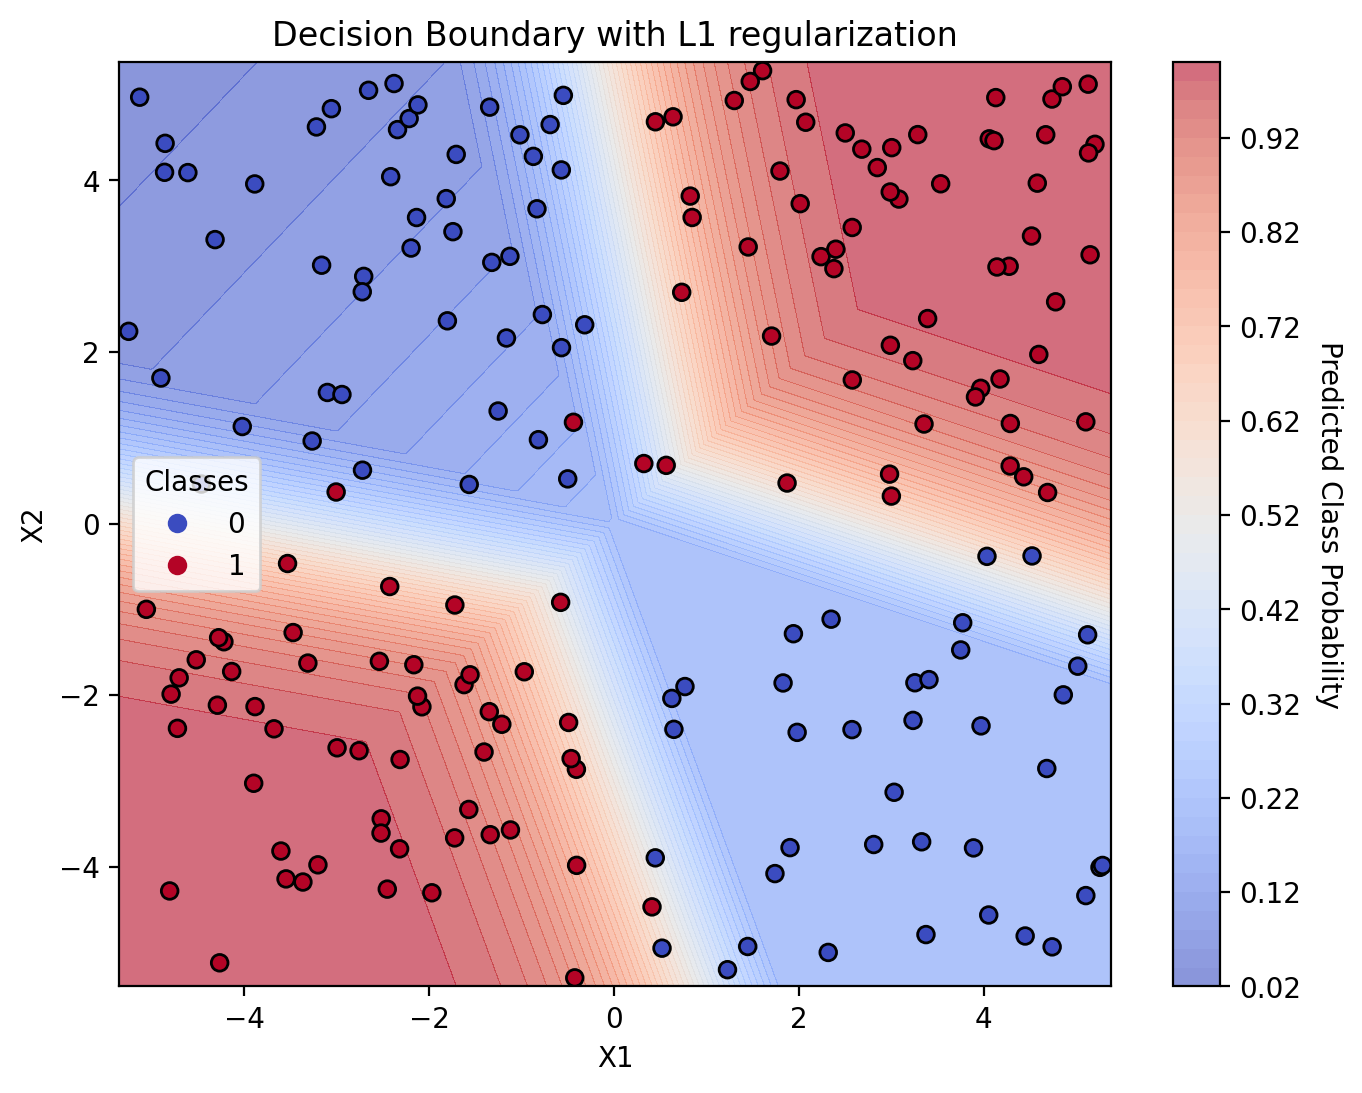

In [16]:
print("For Test Data:")
test_acc_l1 = calculate_accuracy(best_model_l1, X_test_tensor, y_test_tensor)

plot_decision_boundary(best_model_l1,X_test_tensor,y_test_tensor, title="Decision Boundary with L1 regularization")

L1 regularization often drives smaller weights to zero, effectively reducing the model's complexity. L1 regularization encourages sparsity, meaning it tends to zero out less important weights or features. 

The decision boundary may appear slightly simplified compared to the unregularized MLP. L1 Regularization may overly simplify the model by driving some weights to zero, potentially impairing the MLP’s ability to capture the non-linear boundaries required for XOR. This trade-off reduces overfitting but may slightly underfit the data if regularization is too strong.  If the penalty coefficient is high, some details of the XOR shape may be smoothed out.

The drop in accuracy here with L1 (from 98.5% to 96%) may indicate that sparsity isn’t providing a significant benefit here. XOR datasets don’t typically have redundant features, so the regularization's attempt to reduce weights to zero might slightly impact performance.


## MLP with L2 Regularization

In [17]:
# Function to train the model with L2 regularization and return validation accuracy
def train_model_with_l2(X_train, y_train, X_val, y_val, input_size, hidden_size, output_size, l2_lambda, num_epochs, learning_rate=0.01):
    torch.manual_seed(0)
    np.random.seed(0)
    # Instantiate the model, loss function, and optimizer
    model = MLP(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with L2 regularization
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Compute L2 regularization term (sum of squared parameters)
        l2_norm = sum(torch.sum(param ** 2) for param in model.parameters() if param.requires_grad)
        loss += l2_lambda * l2_norm  # Add L2 regularization term to the loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate validation accuracy
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = (val_predictions == y_val).float().mean().item() * 100

    return model, val_accuracy


In [18]:
X_train_l2, X_val_l2, y_train_l2, y_val_l2 = train_test_split(X_train_tensor, y_train, test_size=0.2, random_state=0)

# Convert data to tensors
X_train_l2_tensor = torch.FloatTensor(X_train_l2)
y_train_l2_tensor = torch.FloatTensor(y_train_l2).view(-1, 1)
X_val_l2_tensor = torch.FloatTensor(X_val_l2)
y_val_l2_tensor = torch.FloatTensor(y_val_l2).view(-1, 1)

L2 Lambda: 0.001, Validation Accuracy: 100.00%
L2 Lambda: 0.005, Validation Accuracy: 100.00%
L2 Lambda: 0.01, Validation Accuracy: 100.00%
L2 Lambda: 0.05, Validation Accuracy: 97.50%
L2 Lambda: 0.1, Validation Accuracy: 92.50%
L2 Lambda: 0.5, Validation Accuracy: 50.00%

Best L2 Penalty: 0.01 with Validation Accuracy: 100.00%


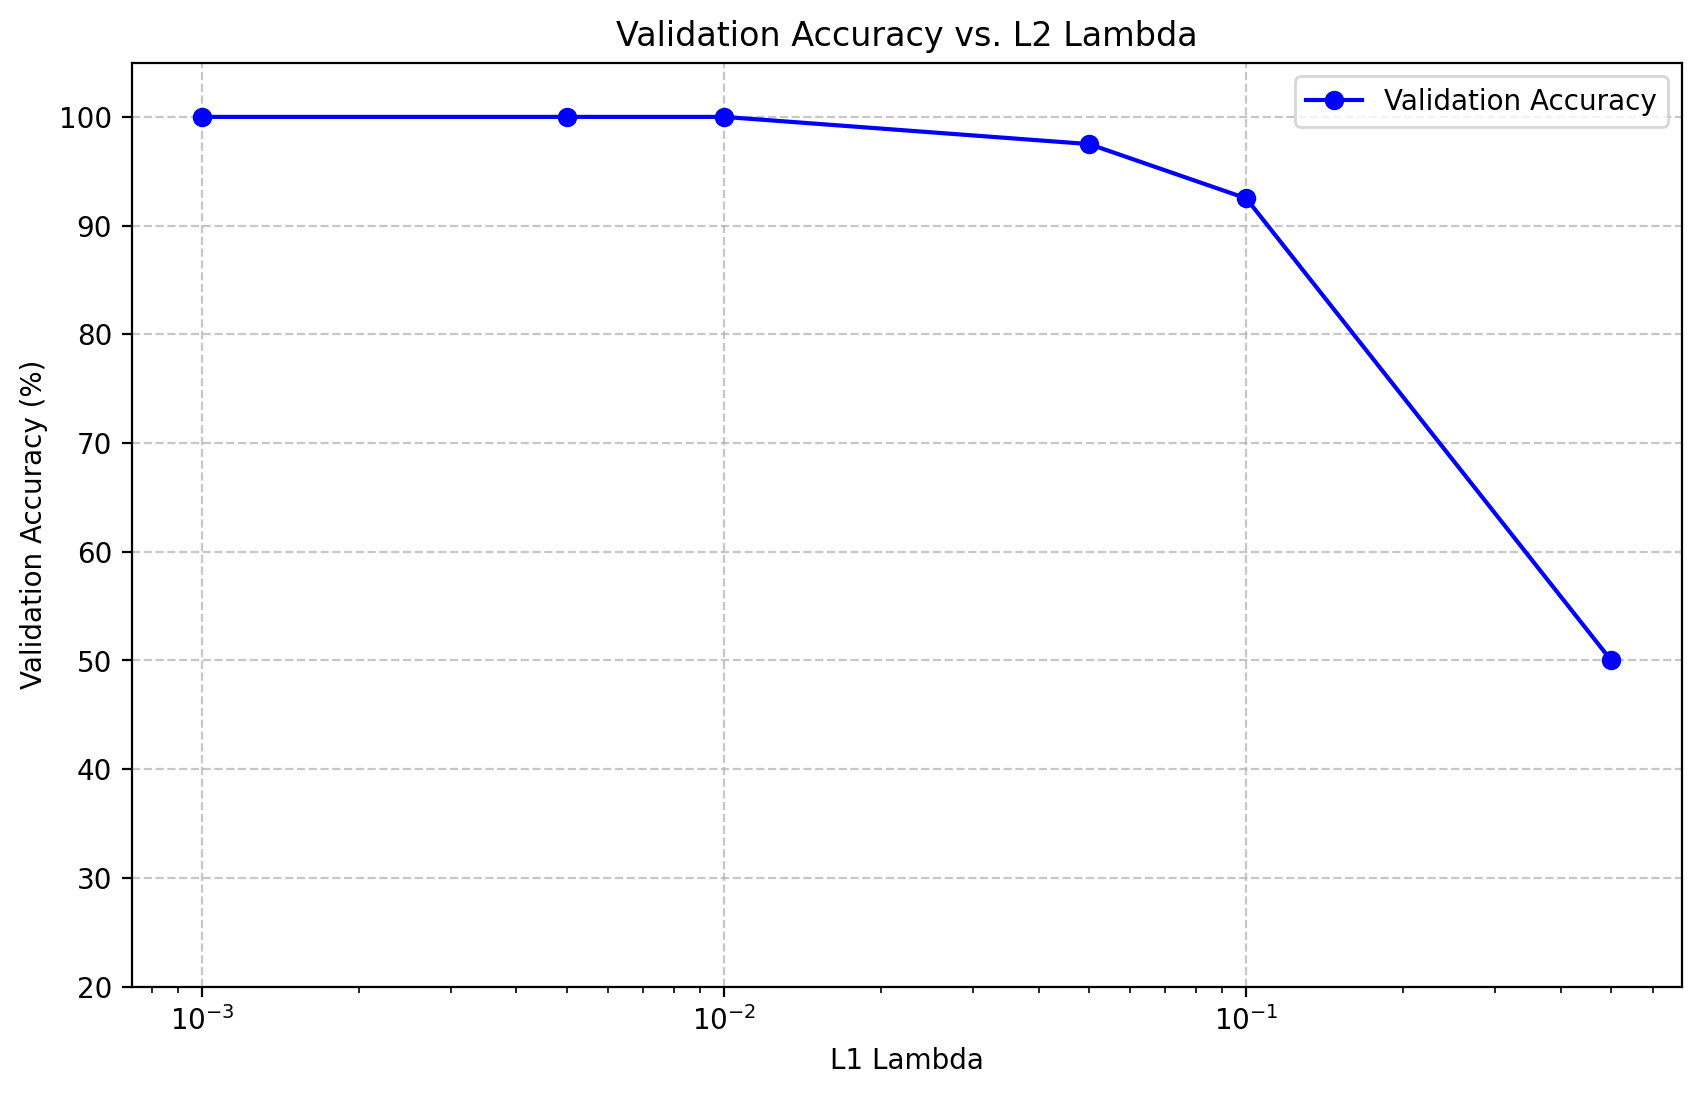

In [19]:
# Main training loop to evaluate and store validation accuracy for each L2 lambda
l2_penalties = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
validation_accuracies = []
best_l2_lambda = None
best_val_accuracy = 0

for l2_lambda in l2_penalties:
    # print(f"\nTraining with L2 Penalty (weight decay): {l2_lambda}")
    _, val_accuracy = train_model_with_l2(
        X_train_l2_tensor, y_train_l2_tensor, X_val_l2_tensor, y_val_l2_tensor,
        input_size=2, hidden_size=10, output_size=1,
        l2_lambda=l2_lambda, num_epochs=100, learning_rate=0.01
    )

    print(f"L2 Lambda: {l2_lambda}, Validation Accuracy: {val_accuracy:.2f}%")
    validation_accuracies.append(val_accuracy)

    # Update best l2_lambda based on validation accuracy
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_l2_lambda = l2_lambda

print(f"\nBest L2 Penalty: {best_l2_lambda} with Validation Accuracy: {best_val_accuracy:.2f}%")

# Plot L2 lambda vs Validation Accuracy
plot_lambda_vs_accuracy(l2_penalties, validation_accuracies, title="Validation Accuracy vs. L2 Lambda")

In [20]:
best_model_l2,_ = train_model_with_l2(X_train_tensor, y_train_tensor,X_val_l2_tensor, y_val_l2_tensor,
                                       input_size=2, hidden_size=10, output_size=1, l2_lambda=best_l2_lambda, num_epochs=
                                       500, learning_rate=0.01)


For Test Data:
Accuracy: 98.50%


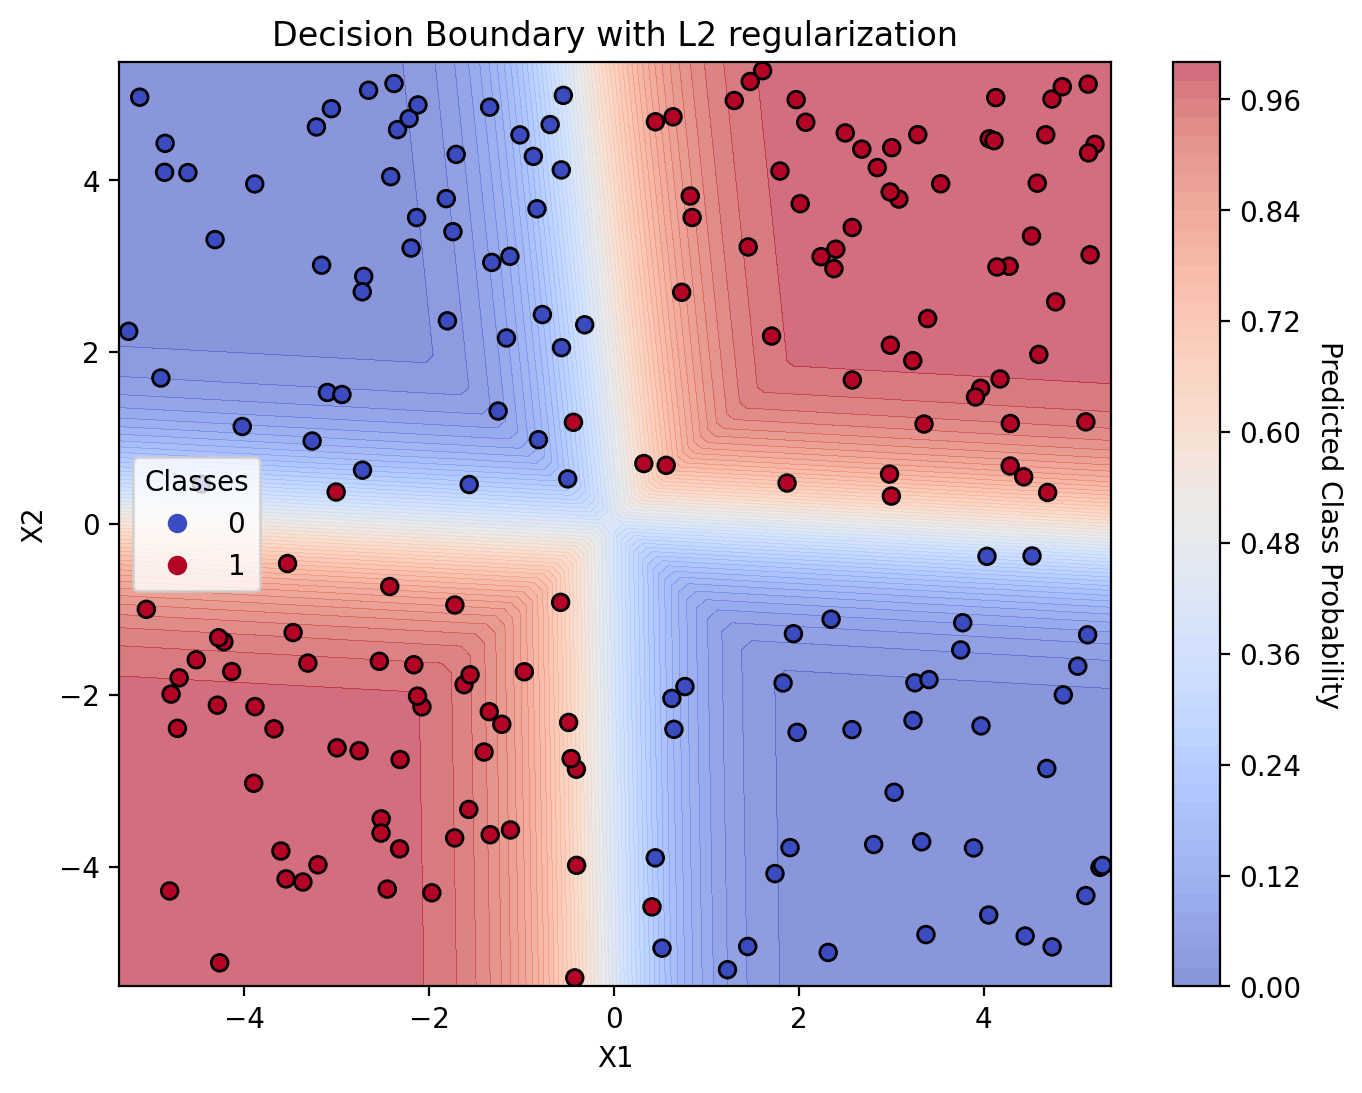

In [21]:
print("For Test Data:")
test_acc_l2 = calculate_accuracy(best_model_l2, X_test_tensor, y_test_tensor)

plot_decision_boundary(best_model_l2,X_test_tensor,y_test_tensor, title="Decision Boundary with L2 regularization")

L2 regularization penalizes large weights, encouraging the model to keep all weights small rather than setting some to zero. This can be effective for maintaining smooth decision boundaries and improving generalization. Accuracy with L2 regularization is often somewhere between the baseline and L1 model, as it strikes a balance between flexibility and control. 

The L2 regularized model reaching 98.5% accuracy (similar as the unregularized model) suggests that small weight penalties helped maintain smooth decision boundaries without disrupting accuracy, as the model structure was likely already close to optimal.

## Additional Features


In [22]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)  
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Convert to PyTorch tensors
X_test_poly_tensor = torch.tensor(X_test_poly, dtype=torch.float32)

# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize the model, loss function, and optimizer
model = LogisticRegressionModel(input_dim=X_train_poly.shape[1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(torch.tensor(X_train_poly, dtype=torch.float32))
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

In [23]:
def plot_decision_boundary_poly(model, X, y, title="Logistic Regression Decision Boundary"):
    # Define bounds of the grid
    x_min, x_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    y_min, y_max = X[:, 2].min() - 0.1, X[:, 2].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Get model predictions over the grid with transformed polynomial features
    grid_points = poly.transform(np.c_[xx.ravel(), yy.ravel()])
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    with torch.no_grad():
        Z = model(grid_tensor)
    
    Z = (Z > 0.5).float().numpy().reshape(xx.shape)

    # Plot decision boundary with hard separation
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.8)

    # Scatter the points with labels
    scatter = plt.scatter(X[:, 1], X[:, 2], c=y, cmap='coolwarm', edgecolor='k', marker='o')

    # Set color bar for the classes
    cbar = plt.colorbar(contour, ticks=[0, 1])
    cbar.set_label("Predicted Class", rotation=270, labelpad=15)

    # Set labels and title
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)

    # Display legend
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()


For Test Data:
Accuracy: 98.50%


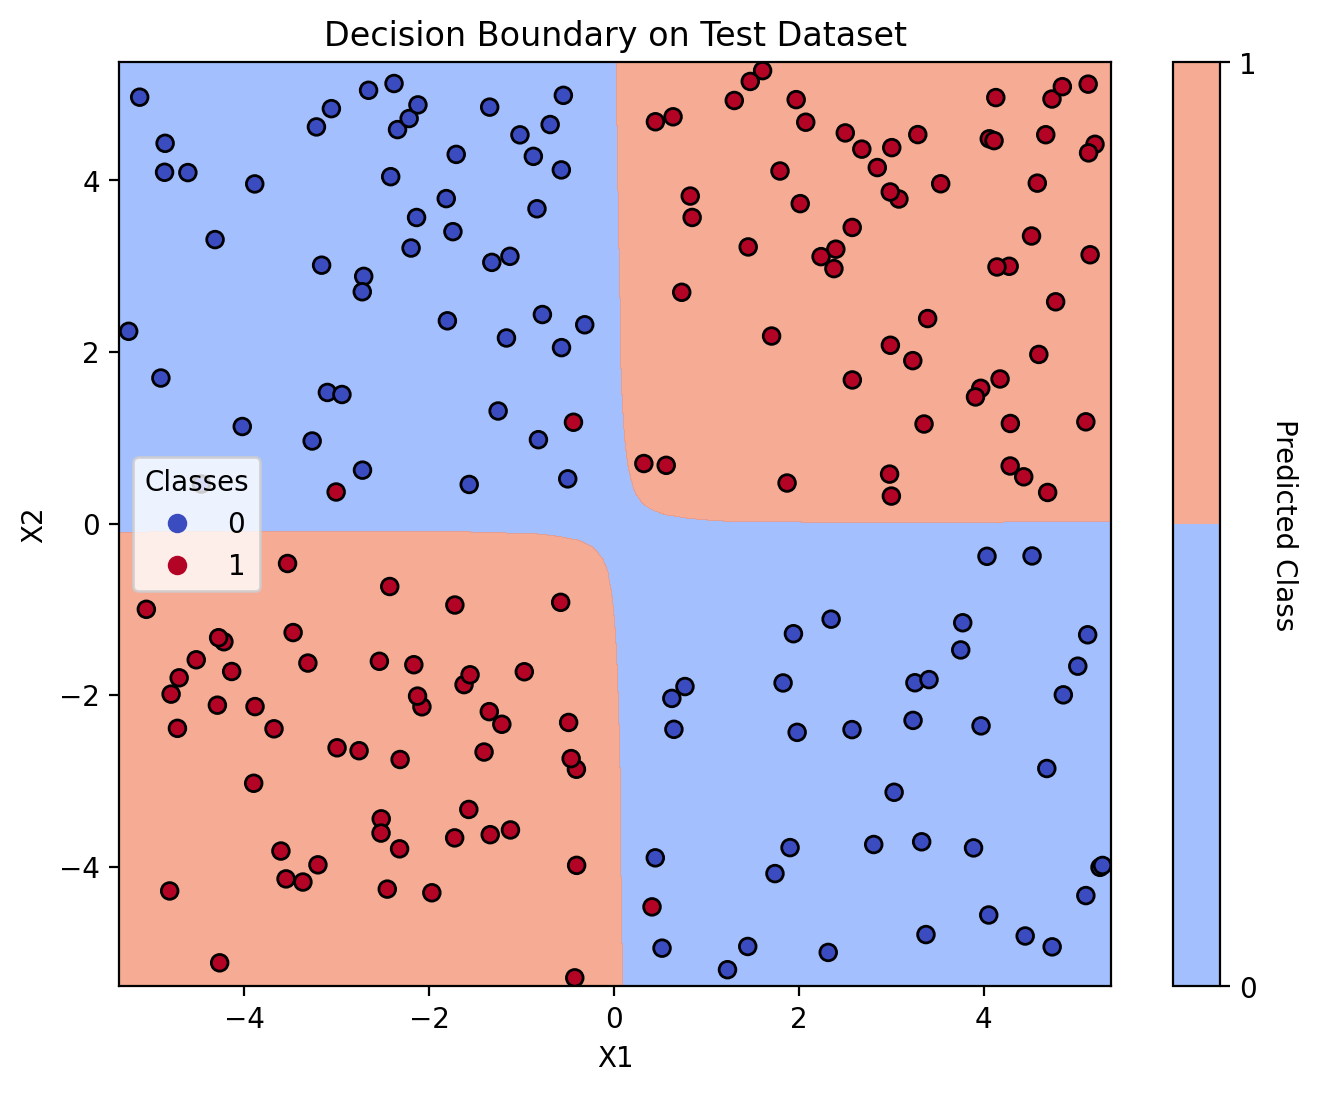

In [24]:
print("For Test Data:")
# Calculate and display accuracy on the test dataset
calculate_accuracy(model, X_test_poly_tensor, y_test_tensor)

# Plot decision boundary on the test dataset
plot_decision_boundary_poly(model, X_test_poly, y_test, title="Decision Boundary on Test Dataset")

Logistic regression by itself struggles with XOR data because of its linear nature. However, adding polynomial features can enable it to capture non-linear boundaries. Here, polynomial features enable logistic regression to capture a basic XOR shape, though it’s less flexible than an MLP, which can more accurately adapt to complex patterns in data. We can see a boundary that roughly follows the XOR pattern but is less precise or less flexible compared to the MLPs. The boundary looks more polygonal in shape. 

Polynomial features enable logistic regression to separate the XOR classes, but this approach is less adaptive than the MLPs. It demonstrates the necessity of additional features in simpler models for non-linear tasks like XOR. 